In [1]:
"""
This notebook is used to verify the configurator.py file.
"""

%load_ext autoreload
%autoreload 2

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
from pathlib import Path
import yaml
import argparse
import numpy as np
import pprint

import torch
from torch.utils.data import TensorDataset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar

from neurorient.model           import NeurOrientLightning
from neurorient.dataset         import TensorDatasetWithTransform
from neurorient.logger          import Logger
from neurorient.image_transform import RandomPatch
from neurorient.configurator    import Configurator
# from neurorient.lr_scheduler    import CosineLRScheduler
from neurorient.config          import _CONFIG
from neurorient.utils_config    import (
    prepare_Slice2RotMat_config, prepare_IntensityNet_config, prepare_optimization_config)

torch.autograd.set_detect_anomaly(False)    # [WARNING] Making it True may throw errors when using bfloat16
                                            # Reference: https://discuss.pytorch.org/t/convolutionbackward0-returned-nan-values-in-its-0th-output/175571/4
                                            
logger = Logger()

In [16]:
# [[[ ARG ]]]
# parser = argparse.ArgumentParser(description="Load training configuration from a YAML file to a dictionary.")
# parser.add_argument('-yf', '--yaml_file', help="Path to the YAML file", dest='yaml_file', type=str, required=True)

# args = parser.parse_args()

args = argparse.Namespace(
    yaml_file='/global/homes/z/zhantao/Projects/NeuralOrientationMatching/base_config_resnet_coslr_patch.yaml')

In [23]:
# [[[ HYPER-PARAMERTERS ]]]
# Load CONFIG from YAML
fl_yaml = args.yaml_file

with open(fl_yaml, 'r') as fh:
    config_dict = yaml.safe_load(fh)
CONFIG = Configurator.from_dict(config_dict)
logger.log(f"loaded configuration from yaml_file: {fl_yaml}.")

merged_config = CONFIG.merge_with_priority(_CONFIG, self_has_priority=True)
logger.log(f"overwrite default model configurations with customed configurations.")


if hasattr(merged_config.TRAINING, 'SEED'):
    L.seed_everything(merged_config.TRAINING.SEED)
    logger.log(f"SEED set to {merged_config.TRAINING.SEED}.")
else:
    logger.log(f"SEED not specified and not set.")

# ...Checkpoint
dir_chkpt           = Path(os.path.join(merged_config.TRAINING.BASE_DIRECTORY, merged_config.TRAINING.CHKPT_DIRECTORY))
dir_chkpt.mkdir(parents=True, exist_ok=True)
logger.log(f"checkpoints will be saved to {dir_chkpt}.")

# ...Dataset
dir_dataset       = merged_config.DATASET.DATASET_DIRECTORY
# necessary info to fetch data file name
pdb               = merged_config.DATASET.PDB
poisson           = merged_config.DATASET.POISSON
increase_factor   = merged_config.DATASET.INCREASE_FACTOR
num_images        = merged_config.DATASET.NUM_IMG
data_file_name = f'{pdb}_increase{increase_factor}_poisson{poisson}_num{num_images//1000}K.pt'
logger.log(f'data read from {data_file_name}')

# necessary info to define datasets
frac_train        = merged_config.DATASET.FRAC_TRAIN
size_batch        = merged_config.DATASET.BATCH_SIZE
num_workers       = merged_config.DATASET.NUM_WORKERS


# ...Training
max_epochs           = merged_config.TRAINING.MAX_EPOCHS
num_gpus             = min(torch.cuda.device_count(), merged_config.TRAINING.NUM_GPUS)
logger.log(f'training the model with {max_epochs} epochs and {num_gpus} GPUs')

Global seed set to 42


[2023-10-02 20:51:18] loaded configuration from yaml_file: /global/homes/z/zhantao/Projects/NeuralOrientationMatching/base_config_resnet_coslr_patch.yaml.
[2023-10-02 20:51:18] overwrite default model configurations with customed configurations.
[2023-10-02 20:51:18] SEED set to 42.
[2023-10-02 20:51:18] checkpoints will be saved to /pscratch/sd/z/zhantao/neurorient_repo/chkpts.
[2023-10-02 20:51:18] data read from 1BXR_increase10_poissonTrue_num10K.pt
[2023-10-02 20:51:18] training the model with 1000 epochs and 1 GPUs


In [24]:
# [[[ DATASET ]]]
spi_data = torch.load(os.path.join(dir_dataset, data_file_name))

# Set global seed and split data...
data              = spi_data['intensities']
spi_data_train    = data[:int(len(data) * frac_train) ]
spi_data_validate = data[ int(len(data) * frac_train):]

# Set world seed and set up transformation rules
uses_random_patch = merged_config.DATASET.USES_RANDOM_PATCH
if uses_random_patch:
    # set up random patch transformation
    num_patch       = merged_config.DATASET.PATCH.NUM_PATCHES
    size_patch_min  = merged_config.DATASET.PATCH.SIZE_PATCH_MIN
    size_patch_max  = merged_config.DATASET.PATCH.SIZE_PATCH_MAX
    returns_mask    = False
    random_patch = RandomPatch(num_patch       = num_patch,
                               size_patch_min  = size_patch_min,
                               size_patch_max  = size_patch_max,
                               returns_mask    = returns_mask)
    # set up photon fluctuation transformation
    photon_fluctuation = PhotonFluctuation('neurorient/data/image_distribution_by_photon_count.npy')
    
    
    
    transform_list   = (random_patch, photon_fluctuation, )
    dataset_train    = TensorDatasetWithTransform(spi_data_train.unsqueeze(1).numpy(), transform_list = transform_list, uses_norm = False)
    dataset_validate = TensorDatasetWithTransform(spi_data_validate.unsqueeze(1).numpy(), transform_list = transform_list, uses_norm = False)
    logger.log(f'random patch transformation applied to training and validation datasets.')
else:
    dataset_train    = TensorDataset(spi_data_train.unsqueeze(1))
    dataset_validate = TensorDataset(spi_data_validate.unsqueeze(1))
    logger.log(f'NO random patch transformation applied to training and validation datasets.')

logger.log(f'created training dataset with {len(dataset_train)} images and validation dataset with {len(dataset_validate)} images.')
    

# lightning will handle the samplers for those dataloaders
sampler_train    = None
dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                sampler     = sampler_train,
                                                shuffle     = True,
                                                pin_memory  = True,
                                                batch_size  = size_batch,
                                                num_workers = num_workers, )

sampler_validate    = None
dataloader_validate = torch.utils.data.DataLoader( dataset_validate,
                                                   sampler     = sampler_validate,
                                                   shuffle     = False,
                                                   pin_memory  = True,
                                                   batch_size  = size_batch,
                                                   num_workers = num_workers, )

[2023-10-02 20:51:22] created training dataset with 9000 images and validation dataset with 1000 images.


In [39]:
image_distribution_by_photon_count = np.load('neurorient/data/image_distribution_by_photon_count.npy')

In [115]:
from neurorient.image_transform import PhotonFluctuation

pf = PhotonFluctuation('neurorient/data/image_distribution_by_photon_count.npy')

x_range = np.linspace(0, 2.5, 1000).reshape(-1, 1)
log_densities = pf.kde.score_samples(x_range)
densities = np.exp(log_densities)


/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


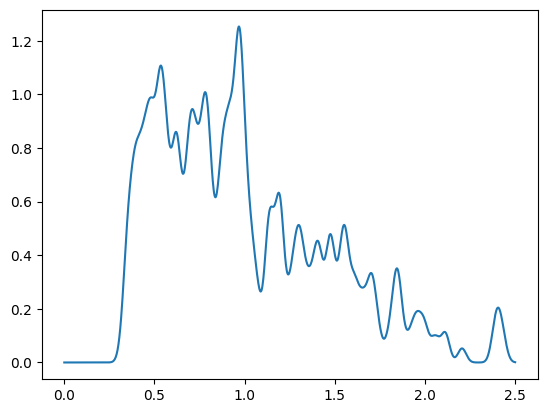

In [116]:
# plt.plot(image_distribution_by_photon_count[0], image_distribution_by_photon_count[1])
plt.plot(x_range, densities)

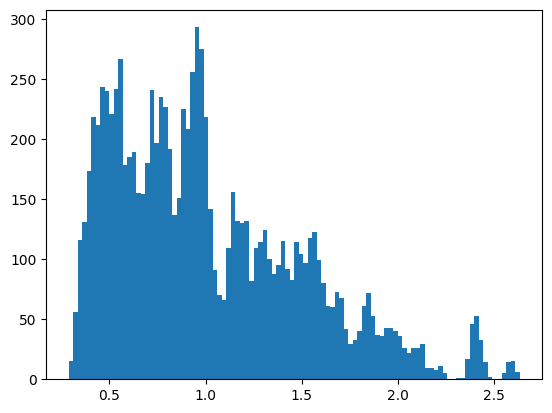

In [117]:
samples = pf.kde.sample(10000)
plt.hist(samples, bins=100);

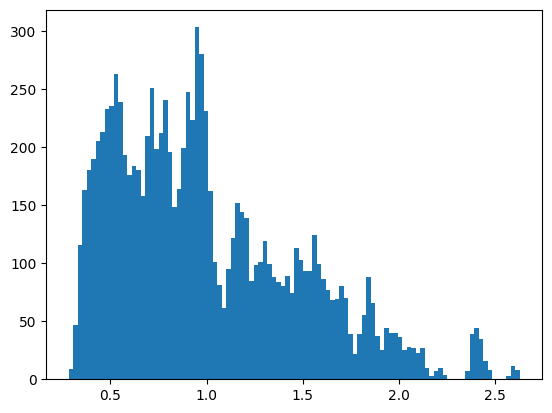

In [121]:
plt.hist(pf(torch.ones(10000, 1, 64, 64)).mean(dim=(1, 2, 3)).numpy(), bins=100);

In [7]:
# [[[ MODEL ]]]
over_sampling = merged_config.MODEL.OVERSAMPLING
photons_per_pulse = merged_config.DATASET.INCREASE_FACTOR * 1e12
config_optimization = prepare_optimization_config(merged_config)
config_intensitynet = prepare_IntensityNet_config(merged_config)
config_slice2rotmat = prepare_Slice2RotMat_config(merged_config)
model = NeurOrientLightning(
    spi_data['pixel_position_reciprocal'],
    over_sampling=over_sampling, 
    photons_per_pulse=photons_per_pulse,
    use_bifpn=merged_config.MODEL.USE_BIFPN,
    config_slice2rotmat=config_slice2rotmat,
    config_intensitynet=config_intensitynet,
    config_optimization=config_optimization
)
logger.log( 
    'arguments being used in building the model:\n',
    f'over_sampling={over_sampling}\n',
    f'photons_per_pulse={photons_per_pulse:.2e}\n',
    'config_slice2rotmat: ', '\n', pprint.pformat(config_slice2rotmat), '\n',
    'config_optimization: ', '\n', pprint.pformat(config_optimization))

logger.log(
    "model created with the following architecture:\n",
    pprint.pformat(model)
)

[2023-10-02 20:34:42] arguments being used in building the model:
 over_sampling=1.0
 photons_per_pulse=1.00e+13
 config_slice2rotmat:  
 {'input_size': (128, 128),
 'num_blocks': 3,
 'num_features': 64,
 'num_levels': 3,
 'output_channels': {'layer1': 256,
                     'layer2': 512,
                     'layer3': 1024,
                     'layer4': 2048,
                     'relu': 64},
 'pretrained': True,
 'regressor_out_features': 6,
 'scale': -1,
 'size': 50} 
 config_optimization:  
 {'loss_func': 'MSELoss',
 'lr': 0.0003,
 'scheduler': {'min_lr': 1e-07,
               'name': 'CosineLRScheduler',
               'total_epochs': 1000,
               'warmup_epochs': 5},
 'weight_decay': 0.0001}
[2023-10-02 20:34:42] model created with the following architecture:
 NeurOrientLightning(
  (model): NeurOrient(
    (orientation_predictor): Slice2RotMat_BIFPN(
      (backbone): ImageEncoder(
        (backbone): ResNet(
          (conv1): Conv2d(1, 64, kernel_size=(7, 7), stri

In [7]:
checkpoint_callback = ModelCheckpoint(
    every_n_train_steps=10, save_last=True, save_top_k=1, monitor="val_loss",
    filename=f'{pdb}-{{epoch}}-{{step}}'
)

torch.set_float32_matmul_precision('high')

trainer = L.Trainer(
    max_epochs=max_epochs, accelerator='gpu',
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=10)],
    log_every_n_steps=1, devices=num_gpus,
    enable_checkpointing=True, default_root_dir=dir_chkpt)

# dump configuration to file for later reference
dump_yaml_fname = Path(os.path.join(trainer.logger.save_dir, 'lightning_logs', f'version_{trainer.logger.version}', 'input.yaml'))
dump_yaml_fname.parent.mkdir(parents=True, exist_ok=True)
merged_config.dump_to_file(dump_yaml_fname)

dump_log_fname = Path(os.path.join(trainer.logger.save_dir, 'lightning_logs', f'version_{trainer.logger.version}', 'log.txt'))
dump_log_fname.parent.mkdir(parents=True, exist_ok=True)
logger.dump_to_file(dump_log_fname)

trainer.fit(model, dataloader_train, dataloader_validate)

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-p ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)


Validation: 0it [00:00, ?it/s]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
